# Séance 3 - Compléments

Dans cette séance nous travaillerons avec le dataset d'images [CIFAR10](https://keras.io/api/datasets/cifar10/) qui correspond à des petites images en couleurs. Notre objectif est de construire un réseau de neurones convolutionnel capable d'identifier chacun des dix types en exploitant quelque-unes des nouvelles méthodes décrites en cours.

## Exploration des données

Commençons par importer les données.

In [134]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

from tensorflow import keras

(X_train, y_train), (X_valid, y_valid) = keras.datasets.cifar10.load_data()

label_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck  ",
}

Regardons la structure d'*y_train* avec son premier élément.

In [135]:
print(y_train[0])

[6]


Au lieu d'avoir un entier, nous avons un array. Pour pouvoir travailler, nous allons devoir modifier la structure de *y_train* et *y_valid*. Il faudrait passer d'un vecteur de taille $n$ à une matrice de type one-hot encoding de taille $(n, 10)$.

**Consigne** : À l'aide de la fonction [`to_categorical`](https://keras.io/2.16/api/utils/python_utils/#tocategorical-function), modifier *y_train* et *y_valid*.

In [136]:
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_valid = keras.utils.to_categorical(y_valid, num_classes=10)

print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


**Consigne** : Afficher plusieurs images du dataset d'entraînement aléatoirement. On pourra utiliser la fonction [`imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) et le dictionnaire.

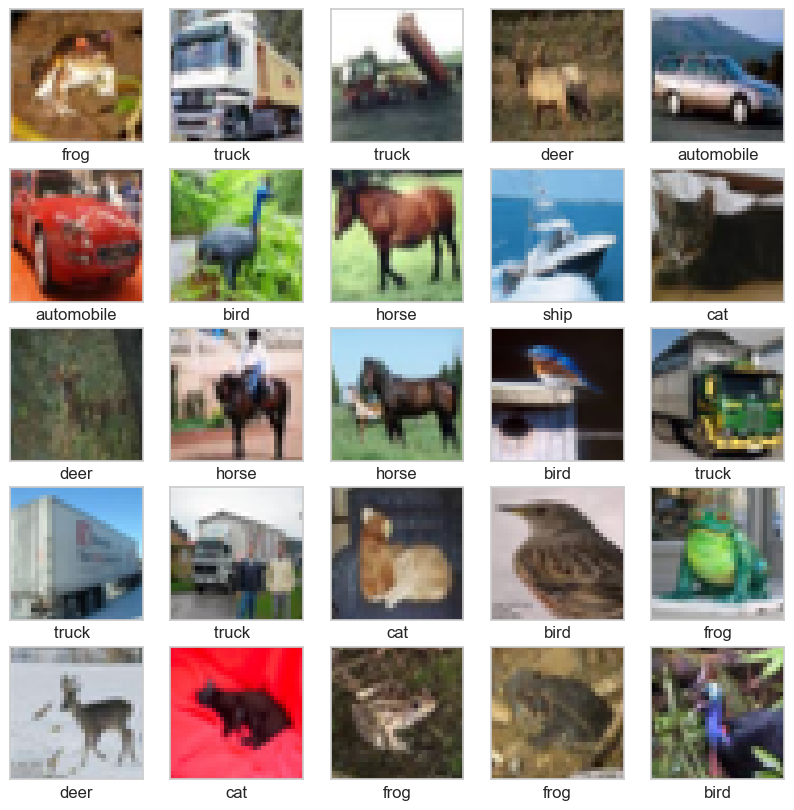

In [137]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(label_map[np.argmax(y_train[i])])
plt.show()

**Consigne** : Standardiser les données en utilisant la classe [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). On commencera par applatir les images en utilisant la méthode [`reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html), puis on applique le pré-processing et on termine par reformer la matrice. Attention à bien respecter les dimensions d'origines de l'image.

In [138]:
from sklearn.preprocessing import StandardScaler

X_train_reshaped = X_train.reshape(-1, 32 * 32 * 3)
X_valid_reshaped = X_valid.reshape(-1, 32 * 32 * 3)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(-1, 32, 32, 3)
X_valid_scaled = scaler.transform(X_valid_reshaped).reshape(-1, 32, 32, 3)

X_train = X_train_scaled.astype(np.float32)
X_valid = X_valid_scaled.astype(np.float32)

print(X_train.shape)
print(X_valid.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Modélisation

On souhaite visualiser les différentes courbes d'apprentissages obtenues par différent optimizer. Pour pouvoir le faire, nous allons devoir choisir les optimizers à comparer et lancer l'entraîner de plusieurs modèles. Commençons par définir une architecture avec une fonction de sorte à pouvoir simplement générer des modèles lors de la comparaisons entre les optimizers.

**Consigne** : Définir une fonction `get_model` qui ne prend pas de paramètre et qui renvoie un modèle convolutionnel de moins de 200k paramètres en utilisant des couches de régularisations au choix.

In [139]:
def get_model() -> keras.Model:
    return keras.Sequential(
        [
            keras.layers.InputLayer(shape=(32, 32, 3)),
            keras.layers.Conv2D(
                filters=32,
                kernel_size=3,
                activation="relu",
                padding="same",
            ),
            keras.layers.Dropout(0.2),
            keras.layers.Conv2D(
                filters=32,
                kernel_size=3,
                activation="relu",
                padding="same",
            ),
            keras.layers.MaxPooling2D(pool_size=2),
            keras.layers.Conv2D(
                filters=16,
                kernel_size=3,
                activation="relu",
                padding="same",
            ),
            keras.layers.Dropout(0.2),
            keras.layers.Conv2D(
                filters=16,
                kernel_size=3,
                activation="relu",
                padding="same",
            ),
            keras.layers.Flatten(),
            keras.layers.Dense(10, activation="softmax"),
        ],
    )



model = get_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_73 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,058 (226.79 KB)

 Trainable params: 58,058 (226.79 KB)

 Non-trainable params: 0 (0.00 B)

Nous avons modifié la structure de *y_train* et *y_valid*, nous devons adapter la fonction de perte à optimiser en conséquence. Cette fois on considérera la fonction de perte [`CategoricalCrossentropy`](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) au lieu de [`SparseCategoricalCrossentropy`](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) que l'on utilisait jusqu'à présent.

**Consigne** : Définir une fonction `compile_train` qui prend en paramètre:
* *optimizer_function* : l'instanciation de la classe de l'optimizer
* *learning_rate* : le learning rate associé à l'optimizer
* Et des [kwargs](https://book.pythontips.com/en/latest/args_and_kwargs.html)

La fonction renvoie l'historique d'apprentissage du modèle définit par la fonction `get_model`. La fonction doit compiler le modèle avec l'optimizer définit en paramètre et l'entraîner avec les paramètres définit dans les kwargs.

In [140]:
def compile_train(
    optimizer_function: str,
    learning_rate: float,
    **kwargs,
) -> keras.callbacks.History:
    model = get_model()
    optimizer = optimizer_function(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        **kwargs,
    )


**Consigne** : Valider le bon fonctionnement de la fonction `compile_train` sur quelques époques.

In [141]:
epochs = 5
batch_size = 64
history_adam = compile_train(
    keras.optimizers.Adam,
    learning_rate=0.001,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.4744 - loss: 1.4691 - val_accuracy: 0.5455 - val_loss: 1.3027
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.6046 - loss: 1.1210 - val_accuracy: 0.6342 - val_loss: 1.0331
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6577 - loss: 0.9842 - val_accuracy: 0.6728 - val_loss: 0.9386
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.6874 - loss: 0.8941 - val_accuracy: 0.6752 - val_loss: 0.9314
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7079 - loss: 0.8316 - val_accuracy: 0.6953 - val_loss: 0.8628


Pour s'affranchir un peu de l'aléatoire, nous proposons de lancer trois fois les différents schéma d'optimisation pour les comparer. La légende sera composée du nom de l'optimizer et la valeur du learning rate sélectionnée. La classe [`optimizer`](https://keras.io/api/optimizers/#optimizer-class) de Keras permet d'obtenir ces informations comme suit:

In [142]:
learning_rate = 0.001
epochs = 20
batch_size = 64
optimizers = [
    keras.optimizers.SGD,
    keras.optimizers.AdamW,
    keras.optimizers.Adam,
]

histories = []
for optimizer in optimizers:
    history = compile_train(
        optimizer,
        learning_rate=learning_rate,
        epochs=epochs,
        batch_size=batch_size,
    )
    name = optimizer.__name__
    label = f"{name} (lr={learning_rate:.06})"
    histories.append({"label": label, "history": history})

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.1829 - loss: 2.2094 - val_accuracy: 0.2651 - val_loss: 2.0630
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.2754 - loss: 2.0188 - val_accuracy: 0.3196 - val_loss: 1.9536
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.3111 - loss: 1.9346 - val_accuracy: 0.3469 - val_loss: 1.8800
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.3397 - loss: 1.8597 - val_accuracy: 0.3724 - val_loss: 1.8069
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.3697 - loss: 1.7821 - val_accuracy: 0.3944 - val_loss: 1.7373
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.3966 - loss: 1.7081 - val_accuracy: 0.4239 - val_loss: 1.6589
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.4165 - loss: 1.6502 - val_accuracy: 0.4155 - val_loss: 1.6464
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.4320 - loss: 1.6071 - 

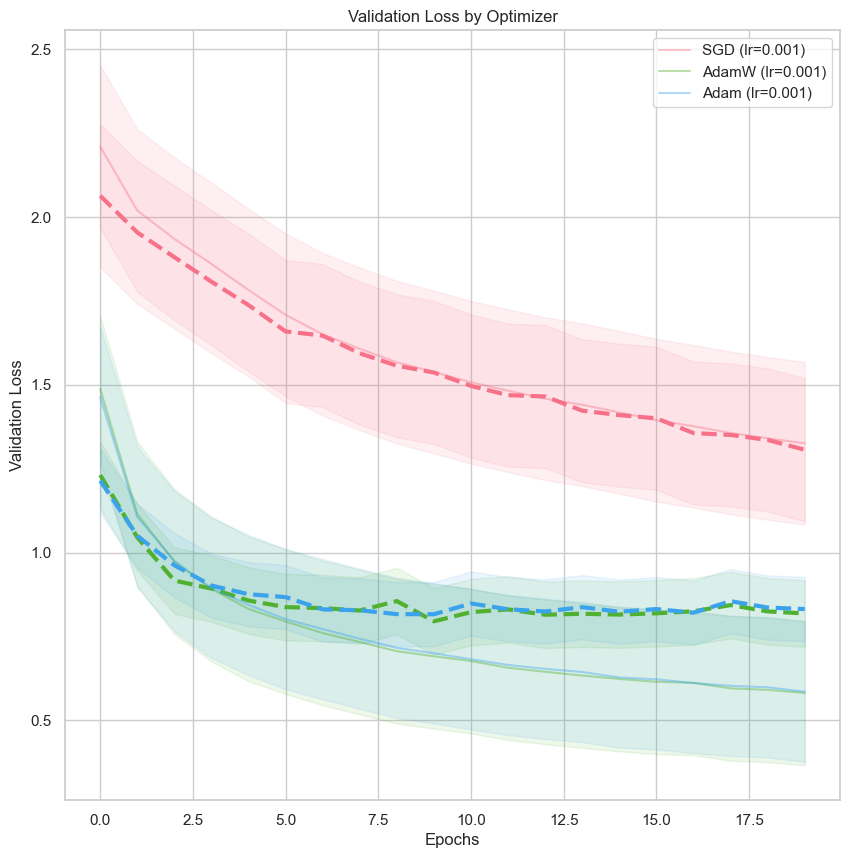

In [143]:
plt.figure(figsize=(10, 10))
colors = sns.color_palette("husl", len(histories))
for i, record in enumerate(histories):
    label = record["label"]
    history = record["history"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    mean_train = np.mean(loss)
    std_train = np.std(loss)
    mean_val = np.mean(val_loss)
    std_val = np.std(val_loss)

    plt.plot(history.history["loss"], label=label, color=colors[i], alpha=0.4)
    plt.fill_between(
        range(len(loss)),
        np.array(loss) - np.array(std_train),
        np.array(loss) + np.array(std_train),
        color=colors[i],
        alpha=0.1,
    )
    plt.plot(history.history["val_loss"], linestyle="--", color=colors[i], linewidth=3)
    plt.fill_between(
        range(len(val_loss)),
        np.array(val_loss) - np.array(std_val),
        np.array(val_loss) + np.array(std_val),
        color=colors[i],
        alpha=0.1,
    )
plt.title("Validation Loss by Optimizer")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

**Consigne** : Écrire une boucle d'entraînement qui va stocker dans une liste les courbes d'apprentissage. Chaque élément de la liste correspondra à un dictionnaire avec pour clé:
* *type*: le nom de l'optimizer
* *history*: l'historique d'apprentissage

Il faut maintenant visualiser les résultats. Commençons par préparer les données.

**Consigne** : Définir une fonction `agregate_result` qui prend en paramètre:
* *results*: le dictionnaire de résultat, au format décrit précédemment
* *network_type*: chaîne de caractère identifiant le type de réseau
* *metric_name*: le nom de la métrique d'intérêt

La fonction renverra deux matrices de tailles (nombre de comparaisons, nombre d'époque) : une pour le dataset d'entraînement et une pour le dataset de validation. On concatène donc les différentes courbes d'apprentissage.

**Consigne** : Visualiser les courbes d'apprentissage en faisant apparaître des intervals de confiance. On prendra exemple sur la fonction `show_results` du TP précédent. Commenter.

## Pour continuer

Choisir une ou plusieurs pistes de recherche parmi les suivantes. Il est possible de choisir une autre direction, mais elle doit être validé auparavant.

1. Nous avons utilisé un learning rate fixe et dans le cours nous avons parlé d'échéancier. Comparer les deux approches, puis se poser la question de l'importance (ou non) d'un phase de warmup.
2. Le [`Dropout`](https://keras.io/api/layers/regularization_layers/dropout/) permet de régulariser un réseau de neurones. Comparer un réseau avec et sans dropout, puis se poser la question de l'importance de la magnitude et du placement d'une couche dropout.